In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from sklearn.neighbors import NearestNeighbors

# adquisicion de datos

In [2]:
# Cargar el dataset de Caltech101 desde TFDS
(train_dataset, test_dataset), dataset_info = tfds.load(
    name='caltech101:3.0.2',
    split=['train[:80%]','test[:90%]'],
    with_info=True,
    as_supervised=True,
    data_dir='',
    download=False
)


In [3]:
# numero de clases
num_classes = dataset_info.features['label'].num_classes
print('Numero de clases:', num_classes)

Numero de clases: 102


# preprocesamiento

In [4]:
# Función para preprocesar las imágenes
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Preprocesar y preparar los datasets
train_dataset = train_dataset.map(preprocess_image).shuffle(1000).batch(32)
test_dataset = test_dataset.map(preprocess_image).batch(32)


In [5]:
# Verificar la estructura del dataset
for image, label in train_dataset.take(1):
    print("Image shape:", image.shape)
    print("Label:", label)
    

Image shape: (32, 224, 224, 3)
Label: tf.Tensor(
[68 13 49  8 54 87 29 55 26 38  9 93 68  7 79 96 23 71 10 97 20 73 39 39
 98 43 47 33 70 26 61 23], shape=(32,), dtype=int64)


# Extraccion de caracteristicas

In [6]:

# Cargar el modelo base
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

#limpiar memoria
del base_model


In [7]:
# Función para extraer características
def extract_features(dataset):
    features = []
    labels = []
    images_list = []
    for images, lbls in dataset:
        feature_maps = model.predict(images)
        features.append(feature_maps)
        labels.append(lbls.numpy())
        images_list.append(images.numpy())
    return features, labels, images_list


In [8]:
# Extraer características para los datasets
train_features, train_labels, train_images = extract_features(train_dataset)

# Aplanar los mapas de características
train_features_flat = np.array([feature.flatten() for batch in train_features for feature in batch])
train_labels_flat = np.array([label for batch in train_labels for label in batch])
train_images_flat = np.array([image for batch in train_images for image in batch])

# Guardar características y etiquetas
np.save('train_features.npy', train_features_flat)
np.save('train_labels.npy', train_labels_flat)
np.save('train_images.npy', train_images_flat)

#limpiar memoria
del train_features, train_labels, train_images, train_features_flat, train_labels_flat, train_images_flat





1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

# indexacion

In [9]:
# Cargar características y etiquetas
train_features_flat = np.load('train_features.npy')
train_labels_flat = np.load('train_labels.npy')
train_images_flat = np.load('train_images.npy')

In [10]:
# Ajustar el modelo NearestNeighbors
nn_model = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(train_features_flat)

In [11]:
import joblib

# Guardar el modelo NearestNeighbors
joblib.dump(nn_model, 'nearest_neighbors_model.pkl')


['nearest_neighbors_model.pkl']

# diseño Motor de busqueda

In [12]:
pox = 0
# Extraer características de una imagen de consulta
query_image, query_label = next(iter(test_dataset.take(1)))
query_image = query_image[pox]  # Obtener la imagen del lote
query_label = query_label[pox]  # Obtener la etiqueta del lote
query_image = tf.expand_dims(query_image, axis=0)  # Añadir dimensión de lote
query_features = model.predict(query_image).flatten().reshape(1, -1)
query_image_display = query_image.numpy()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [13]:
# Encontrar los vecinos más cercanos
distances, indices = nn_model.kneighbors(query_features,n_neighbors=10)
print("Indices of nearest neighbors:", indices)
print("Distances to nearest neighbors:", distances)

Indices of nearest neighbors: [[2005  169 1446 1204 1668 1036 1695  756  704   96]]
Distances to nearest neighbors: [[241.81513456 244.01736062 247.42755354 248.04018714 248.63585871
  249.70625872 250.75559263 250.91681562 251.20823099 251.4120793 ]]


In [14]:
#imprimir las etiquetas de las imágenes más cercanas
print("Labels of nearest neighbors:", [train_labels_flat[idx] for idx in indices[0]])


Labels of nearest neighbors: [29, 29, 29, 12, 29, 12, 42, 29, 29, 29]


(-0.5, 223.5, 223.5, -0.5)

<Figure size 640x480 with 0 Axes>

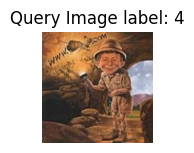

In [15]:
#limpiar ploteo
plt.clf()
# Mostrar la imagen de consulta
plt.figure(figsize=(10, 6))
plt.subplot(1, 6, 1)
plt.imshow(query_image_display[0])
plt.title(f'Query Image label: {query_label.numpy()}')
plt.axis('off')

In [16]:
print(dataset_info.features['label'].names)
print(dataset_info.features['label'].int2str(query_label.numpy()))

['accordion', 'airplanes', 'anchor', 'ant', 'background_google', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'faces', 'faces_easy', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'leopards', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'motorbikes', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 's

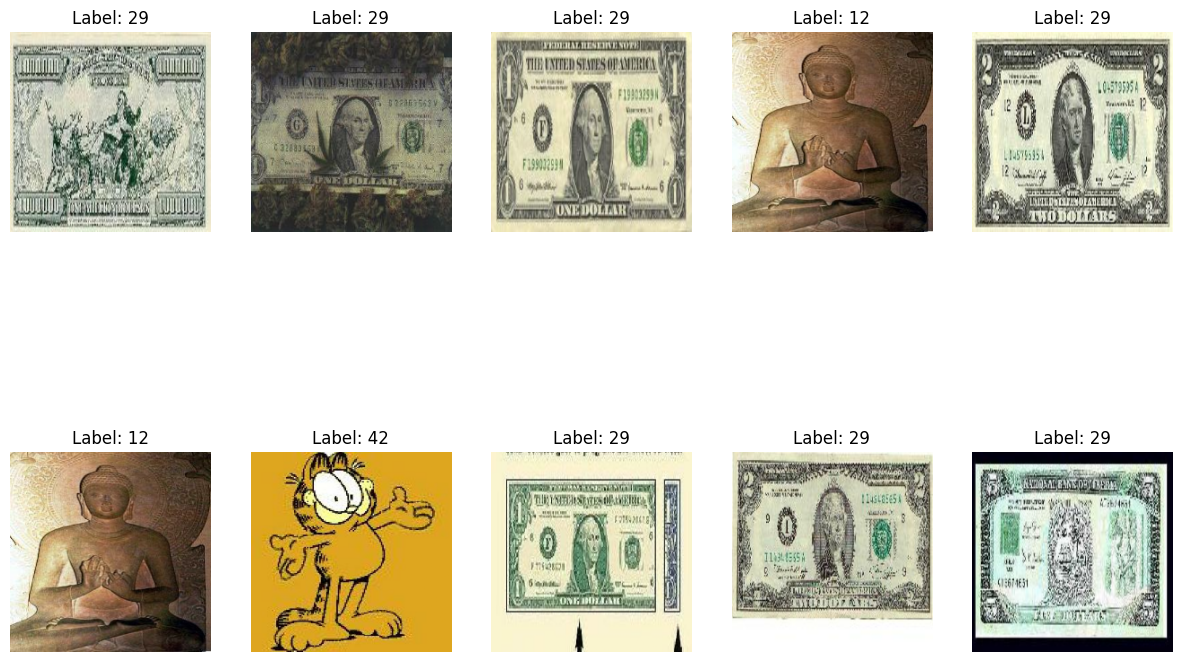

In [17]:
# Mostrar las imágenes de los vecinos más cercanos
plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices[0]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images_flat[idx])
    plt.title(f"Label: {train_labels_flat[idx]}")
    plt.axis('off')

In [18]:
#limpiar memoria
del train_features_flat, train_images_flat, query_image, query_label, query_features, query_image_display, distances, indices

# evaluacion

In [19]:
# obtener las caracteristicas de las imagenes de test
test_features, test_labels, _ = extract_features(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [20]:
print(len(test_features))
print(type(test_features))
print("test_features",test_features[0].shape)
print(type(test_features[0]))

172
<class 'list'>
test_features (32, 5, 5, 2048)
<class 'numpy.ndarray'>


In [21]:
# Aplanar los mapas de características
test_features_flat = np.array([feature.flatten() for batch in test_features for feature in batch])
test_labels_flat = np.array([label for batch in test_labels for label in batch])

# limpiar memoria
del test_features, test_labels


In [22]:
print(test_features_flat.shape)
print(test_labels_flat.shape)

(5476, 51200)
(5476,)


In [23]:
distances_test, indices_test = nn_model.kneighbors(test_features_flat,n_neighbors=5)

In [24]:
#limpiar memoria
del test_features_flat

In [25]:
print("Indices of nearest neighbors:", indices_test.shape)

Indices of nearest neighbors: (5476, 5)


In [26]:
#compara las etiquetas de las imagenes de test con las etiquetas de las imagenes mas cercanas
correct = 0
for i in range(len(test_labels_flat)):
    if test_labels_flat[i] in [train_labels_flat[idx] for idx in indices_test[i]]:
        correct += 1

accuracy = correct / len(test_labels_flat)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Correct: {correct}")
print(f"Total: {len(test_labels_flat)}")


Accuracy: 89.48%
Correct: 4900
Total: 5476


In [27]:
# obtener los labels de las imagenes mas cercanas
print("Labels of nearest neighbors:", [train_labels_flat[idx] for idx in indices_test[0]])

Labels of nearest neighbors: [29, 29, 29, 12, 29]


In [28]:
print([train_labels_flat[idx] for idx in indices_test[:]])

[array([29, 29, 29, 12, 29], dtype=int64), array([89, 89, 89, 89, 89], dtype=int64), array([66, 66, 66, 66, 66], dtype=int64), array([73, 73, 73, 73, 73], dtype=int64), array([29, 42, 42,  4, 84], dtype=int64), array([9, 9, 9, 9, 9], dtype=int64), array([ 4, 29,  4,  4, 95], dtype=int64), array([37, 38, 38, 38, 38], dtype=int64), array([17, 17, 10, 17, 17], dtype=int64), array([38, 38, 38, 38, 38], dtype=int64), array([38, 38, 38, 37, 38], dtype=int64), array([38, 38, 38, 38, 38], dtype=int64), array([99, 99, 99, 99, 99], dtype=int64), array([52, 52, 98, 52, 52], dtype=int64), array([89, 89, 89, 89, 89], dtype=int64), array([42, 10,  4, 42, 42], dtype=int64), array([38, 38, 38, 38, 38], dtype=int64), array([34, 34, 42, 58, 52], dtype=int64), array([56, 56, 56, 56, 56], dtype=int64), array([38, 38, 38, 38, 38], dtype=int64), array([38, 38, 38, 38, 38], dtype=int64), array([95, 95, 95, 95, 95], dtype=int64), array([9, 9, 9, 9, 9], dtype=int64), array([66, 66, 66, 66, 66], dtype=int64), a

In [29]:

for i in range(len(test_labels_flat)):
    if test_labels_flat[i] in [train_labels_flat[idx] for idx in indices_test[i]]:
        correct += 1
        print("Img",i,"correcta")
    else:
        print("Img",i,"incorrecta")
    
    print(f'PL:{[train_labels_flat[idx] for idx in indices_test[i]]}, RL:{test_labels_flat[i]}, Correct percent: {sum([1 for idx in indices_test[i] if train_labels_flat[idx] == test_labels_flat[i]])/len(indices_test[0])*100}%')
    print("------------------------------------------------------")


Img 0 incorrecta
PL:[29, 29, 29, 12, 29], RL:4, Correct percent: 0.0%
------------------------------------------------------
Img 1 correcta
PL:[89, 89, 89, 89, 89], RL:89, Correct percent: 100.0%
------------------------------------------------------
Img 2 correcta
PL:[66, 66, 66, 66, 66], RL:66, Correct percent: 100.0%
------------------------------------------------------
Img 3 correcta
PL:[73, 73, 73, 73, 73], RL:73, Correct percent: 100.0%
------------------------------------------------------
Img 4 correcta
PL:[29, 42, 42, 4, 84], RL:4, Correct percent: 20.0%
------------------------------------------------------
Img 5 correcta
PL:[9, 9, 9, 9, 9], RL:9, Correct percent: 100.0%
------------------------------------------------------
Img 6 incorrecta
PL:[4, 29, 4, 4, 95], RL:75, Correct percent: 0.0%
------------------------------------------------------
Img 7 correcta
PL:[37, 38, 38, 38, 38], RL:37, Correct percent: 20.0%
------------------------------------------------------
Img 8 

In [30]:
# precision, recall, f1-score
from sklearn.metrics import classification_report,accuracy_score, precision_score, recall_score, f1_score

# Obtener las etiquetas predichas
predicted_labels = [train_labels_flat[idx] for idx in indices_test[:,0]]

# Generar el reporte de clasificación
report = classification_report(test_labels_flat, predicted_labels)

# Imprimir el reporte
print(report)


              precision    recall  f1-score   support

           0       1.00      0.91      0.95        23
           1       0.96      0.97      0.96       693
           2       0.33      0.22      0.27         9
           3       0.65      0.92      0.76        12
           4       0.56      0.17      0.26       393
           5       0.88      0.88      0.88        16
           6       0.61      0.77      0.68        22
           7       0.91      0.71      0.80        14
           8       1.00      0.67      0.80         3
           9       0.90      0.72      0.80        89
          10       0.98      0.66      0.79        62
          11       0.83      0.42      0.56        12
          12       1.00      0.74      0.85        47
          13       0.78      0.50      0.61        56
          14       0.76      0.94      0.84        17
          15       0.36      0.73      0.48        11
          16       0.98      1.00      0.99        86
          17       1.00    

In [31]:
accuracy = accuracy_score(test_labels_flat, predicted_labels)
precision = precision_score(test_labels_flat, predicted_labels, average='macro')
recall = recall_score(test_labels_flat, predicted_labels, average='macro')
f1 = f1_score(test_labels_flat, predicted_labels, average='macro')

print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")


Accuracy: 78.56%
Precision: 77.79%
Recall: 78.64%
F1 Score: 74.38%


# evaluacion kevin

In [32]:
# from sklearn.metrics import precision_score, recall_score
# def get_predictions(dataset):
#     y_true = []
#     y_pred = []
#     for images, labels in dataset:
#         feature_maps = model.predict(images)
#         features_flat = feature_maps.reshape((feature_maps.shape[0], -1))
#         distances, indices = nn_model.kneighbors(features_flat)
#         predicted_labels = train_labels_flat[indices[:, 0]]  # Usar el vecino más cercano
#         y_true.extend(labels.numpy())
#         y_pred.extend(predicted_labels)
#     return np.array(y_true), np.array(y_pred)



In [33]:
# # Obtener predicciones para el conjunto de prueba
# y_true, y_pred = get_predictions(test_dataset)

# # Calcular precisión y recall
# precision = precision_score(y_true, y_pred, average='weighted')
# recall = recall_score(y_true, y_pred, average='weighted')

# print(f'Precision: {precision}')
# print(f'Recall: {recall}')

In [34]:
#limpiar memoria
del nn_model, model